# Reading DICOM scans an saving as numpy arrays

In [25]:
import random
import os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [26]:
from lunglens.data import *
from lunglens.segment import prepare_scan, make_lungmask

In [27]:
data_dir = Path('../data/prepared')
dest_root_dir = Path('../data/patches')

## Kaggle: OSIC Pulmonary Fibrosis Progression

In [28]:
ds_dir = data_dir/'osic-pulmonary-fibrosis-progression'
dest_dir = dest_root_dir/'osic-pulmonary-fibrosis-progression/'

## process a scan: read slices and prepare masks

In [48]:
def read_and_mask_scan(scan, dilute_factor, mask_sw=True, verbose=True):
    num_slices = len(list(scan.rglob('*')))
    use_slices = np.arange(1, num_slices, dilute_factor)
    masks = np.zeros((len(use_slices), 512, 512))
    masked_slices = np.zeros((len(use_slices), 512, 512))
    for slice_idx, use_slice in enumerate(use_slices):
        if verbose:
            print(str(scan), slice_idx, use_slice)
        img = prepare_scan(str(scan), slice_size=512, \
                            window=[-600, 900], show_stages=False, slice_idx=use_slice)
        #plt.imshow(img[0], cmap='gray')
        #plt.show()
        #masks[slice_idx] = make_lungmask(img[0], display=False)
        try:
            slc_mask = make_lungmask(img[0], display=False)
        except:
            print('fail on slice', use_slice)
            slc_mask= np.zeros(img[0].shape)
        masks[slice_idx] = slc_mask
        masked_slices[slice_idx] = img * masks[slice_idx] if mask_sw else scan
        #plt.imshow(masked_slices[slice_idx], cmap='gray')
        #plt.show()
    
    return masks, masked_slices
        

In [44]:
all_scans = list(ds_dir.rglob('ID0*'))
masks, masked_slices = read_and_mask_scan(all_scans[0], dilute_factor=20)

..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 0 1
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 1 21
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 2 41
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 3 61
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 4 81
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 5 101
fail on slice 5
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 6 121
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 7 141
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 8 161
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 9 181
..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 10 201
..\data\prepared\osic-pulmonary-fibrosis-progression\I

In [45]:
def patches_from_slices(maseked_slices, masks, patch_size=32, ext_patch_size=40, \
                        patches_per_set=16, max_num_sets=4, bias_mask=0.95, show_patches=False):
    
    max_shift = int((ext_patch_size - patch_size) / 2)
    slice_size = masked_slices.shape[-1]
    num_slices = masked_slices.shape[0]
    patch_start_coor = np.arange(max_shift, slice_size-patch_size-max_shift+1, patch_size, dtype=int)
    #print(patch_start_coor)
    patch_score = np.zeros((num_slices, len(patch_start_coor), len(patch_start_coor)))
    for i_slice in range(num_slices):
        for i0, c0 in enumerate(patch_start_coor):
            for i1, c1 in enumerate(patch_start_coor):
                patch_score[i_slice, i0, i1] = masks[i_slice, c0:c0+patch_size, c1:c1+patch_size].sum()
    # fix scores and introduce randomness
    patch_score = patch_score / (patch_size ** 2)
    patch_score = np.sqrt(patch_score) * bias_mask + (1 - bias_mask)
    patch_score *= np.random.uniform(low=0.5, high=1, size=patch_score.shape)
    # select patches
    patches, patch_positions = [], []
    for i in range(patches_per_set * max_num_sets):
        next_idx = np.unravel_index(patch_score.argmax(), patch_score.shape)
        patch_score[next_idx] = 0
        i0, i1 = patch_start_coor[next_idx[1]] - max_shift, patch_start_coor[next_idx[2]] - max_shift
        patches.append(masked_slices[next_idx[0], i0:i0+ext_patch_size, i1:i1+ext_patch_size])
        patch_positions.append([next_idx[0], i0, i1])
    #
    #print(patch_positions)
    # reorder and group
    p = np.random.permutation(patches_per_set * max_num_sets)
    patches = [patches[i] for i in p]
    patch_positions = [patch_positions[i] for i in p]
    #
    patch_groups = []
    patch_position_groups = []
    for i_set in range(max_num_sets):
        i1, i2 = i_set*patches_per_set, (i_set+1)*patches_per_set
        #print(i1, i2, len(patches), patches[0].shape)
        patch_group, patch_position_group = [], []
        for i in range(i1, i2):
            patch_group.append(patches[i])
            patch_position_group.append(patch_positions[i])
        #print('>>>  ', len(patch_group))
        patch_groups.append(np.array(patch_group))
        patch_position_groups.append(np.array(patch_position_group))
    print(patch_groups[0].shape)
    
    if show_patches:
        for i_set in range(max_num_sets):
            print('\n\n\nshow set', i_set, '\n\n')
            n = np.ceil(np.sqrt(patches_per_set)).astype(int)
            fig, ax = plt.subplots(n, n, figsize=[8, 8])
            i0, i1 = 0, 0
            patches = patch_groups[i_set]
            for patch in patches:
                ax[i0, i1].imshow(patch, cmap='gray')
                ax[i0, i1].axis('off')
                i1 = (i1 + 1) % n
                i0 += 1 if i1==0 else 0
            fig.suptitle('patch bank {}'.format(i_set))
            plt.show()
            
    return patch_groups
        


(4, 512, 512)



show set 0 




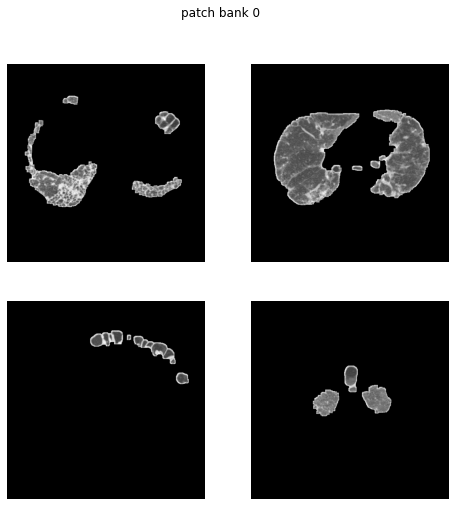




show set 1 




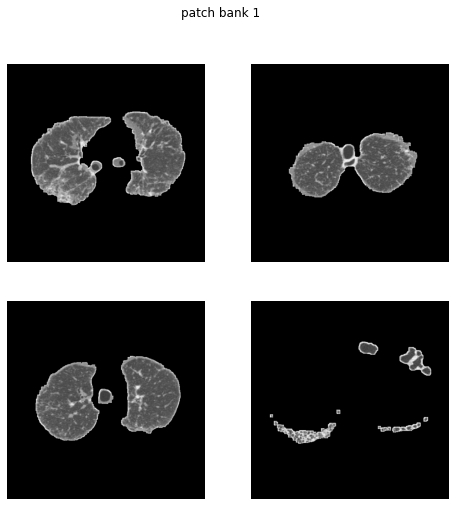




show set 2 




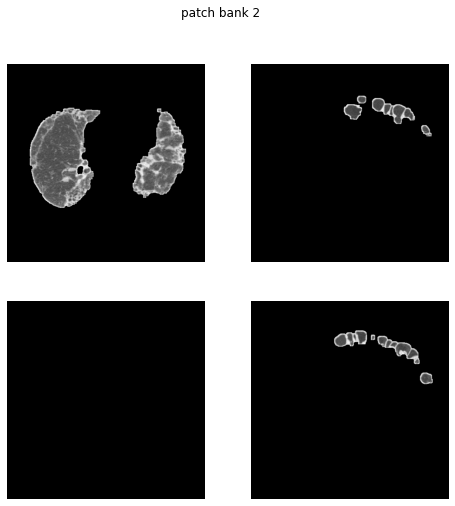




show set 3 




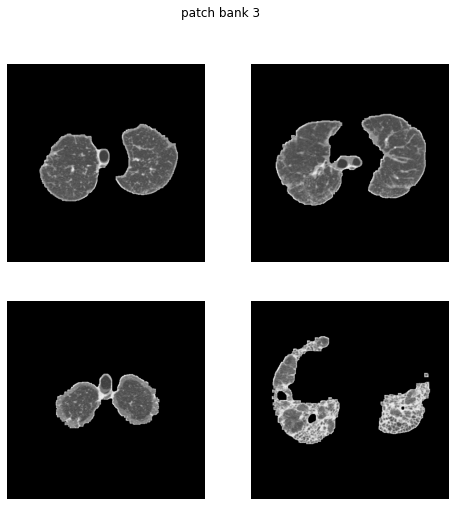

In [46]:
patch_groups = patches_from_slices(masked_slices, masks,  \
                                   patch_size=512, ext_patch_size=512, \
                                   patches_per_set=4, max_num_sets=4, \
                                   bias_mask=0.15, show_patches=True)

##    
## this is the part that creates the patch dataset

In [53]:
# define the paths (again)
data_dir = Path('../data/prepared')
dest_root_dir = Path('../data/patches')
ds_dir = data_dir/'osic-pulmonary-fibrosis-progression'
dest_dir = dest_root_dir/'osic-pulmonary-fibrosis-progression/'

# parameters
mask_lungs = True
slice_dilute_factor = 10
patch_size=32
ext_patch_size=40
patches_per_set=24
max_num_sets=4
bias_mask=0.85

show_example = False

# list of scans
all_scans = list(ds_dir.rglob('ID0*'))

# show example
# this is in order to evaluate the quality of parameters
if show_example:
    scan = random.choice(all_scans)
    print('working on example:', scan)
    masks, masked_slices = read_and_mask_scan(scan, slice_dilute_factor, mask_sw=mask_lungs, verbose=False)
    patch_groups = patches_from_slices(masked_slices, masks,  \
                                       patch_size=patch_size, ext_patch_size=ext_patch_size, \
                                       patches_per_set=patches_per_set, max_num_sets=max_num_sets, \
                                       bias_mask=bias_mask, show_patches=True)

# now systematically craete the patch dataset
for scan_id, scan in enumerate(all_scans):
    print('\n\nworking on scan {} ({} out of {})\n'.format(scan, scan_id, len(all_scans)))
    try:
        masks, masked_slices = read_and_mask_scan(scan, slice_dilute_factor, mask_sw=mask_lungs, verbose=False)
        patch_groups = patches_from_slices(masked_slices, masks,  \
                                           patch_size=patch_size, ext_patch_size=ext_patch_size, \
                                           patches_per_set=patches_per_set, max_num_sets=max_num_sets, \
                                           bias_mask=bias_mask, show_patches=False)
        for i_set in range(len(patch_groups)):
            scan_name = str(scan)[str(scan).find('ID'):]
            os.makedirs(str(dest_dir) + '/' + str(scan_name), exist_ok=True)
            filename = str(dest_dir) + '/' + str(scan_name) + '/' + str(i_set) + '.npy'
            np.save(filename, patch_groups[i_set])
            print('writing:', filename)
    except:
        print('fail on', scan)



working on scan ..\data\prepared\osic-pulmonary-fibrosis-progression\ID00007637202177411956430 (0 out of 175)

fail on slice 101
(24, 40, 40)
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00007637202177411956430/0.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00007637202177411956430/1.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00007637202177411956430/2.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00007637202177411956430/3.npy


working on scan ..\data\prepared\osic-pulmonary-fibrosis-progression\ID00009637202177434476278 (1 out of 175)

(24, 40, 40)
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00009637202177434476278/0.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00009637202177434476278/1.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00009637202177434476278/2.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID0000963720217743

d:\osic_ipf\lunglens\lib-pkg\lunglens\segment.py:109: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=2).fit(np.atleast_2d(blured_img[mask_0].flatten()).T)
d:\osic_ipf\lunglens\lib-pkg\lunglens\segment.py:109: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=2).fit(np.atleast_2d(blured_img[mask_0].flatten()).T)
d:\osic_ipf\lunglens\lib-pkg\lunglens\segment.py:109: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=2).fit(np.atleast_2d(blured_img[mask_0].flatten()).T)
d:\osic_ipf\lunglens\lib-pkg\lunglens\segment.py:109: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=2)

(24, 40, 40)
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00132637202222178761324/0.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00132637202222178761324/1.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00132637202222178761324/2.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00132637202222178761324/3.npy


working on scan ..\data\prepared\osic-pulmonary-fibrosis-progression\ID00133637202223847701934 (60 out of 175)

(24, 40, 40)
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00133637202223847701934/0.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00133637202223847701934/1.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00133637202223847701934/2.npy
writing: ..\data\patches\osic-pulmonary-fibrosis-progression/ID00133637202223847701934/3.npy


working on scan ..\data\prepared\osic-pulmonary-fibrosis-progression\ID00134637202223873059688 (61 out of 175)

(2